# 第4週：對ptt美食版「吃到飽」餐廳進行情緒分析
**Author:** 黃天原<br>
**Date created:** 2021/09/30<br>
**Last modified:** 2024/02/25<br>
本週課程為「情緒分析1」，目的為了解lexicon-base 情緒分析。情緒分析步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「中文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中，我們將會介紹所使用到的套件、資料前處理、lexicon-base 情緒分析

## 大綱
+ 1. 套件說明
+ 2. 資料前處理
    + 2.1 基本資料介紹
    + 2.2 資料清理
    + 2.3 文章斷詞
+ 3. lexicon-base 情緒分析
    + 3.1 準備LIWC情緒字典
    + 3.2 情緒字典與斷詞結果進行合併
    + 3.3 正負向情緒詞彙頻率折線圖圖
    + 3.4 正負向情緒詞彙比例折線圖圖
    + 3.5 正負向情緒分數折線圖圖
    + 3.6 文章為單位的情緒分析
    + 3.7 情緒代表字
    + 3.8 文字雲

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- matplotlib: 繪圖工具。
- wordcloud: 繪製文字雲工具。
- jieba: 中文斷詞工具。

## 本機使用套間
請先於環境中使用 pip install

In [142]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud 
import jieba
%matplotlib inline

## colab 使用套件

In [143]:
# !pip install pandas
# !pip install matplotlib
# !pip install wordcloud
# !pip install jieba

In [144]:
# plt.rcParams['font.sans-serif']=['SimHei'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")


# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

## 2. 資料前處理
如 week3 所示  
使用「吃到飽」作為關鍵字，從工作流程系統中將 ptt 資料下載下來

### 2.1 基本資料介紹
- 資料來源: 工作流程蒐集PTT 美食版 Food 2020-01-10 ~ 2022-12-31 所有文章

In [145]:
df = pd.read_csv("../week3/raw_data/zh_buffet_20_22.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02,justin81828,Food,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KKyosuke"", ""...",118.169.82.96,2020-01-03 00:22:27,ptt
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02,v84454058,Food,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,[],123.194.196.149,2020-01-03 00:22:34,ptt
3,4,https://www.ptt.cc/bbs/Food/M.1578120136.A.276...,[食記]福岡-運河城旁國產牛燒肉-WEST,2020-01-04,Guyinkt,Food,消費時間：2019年/08月\n\n在運河城逛累了當然要吃東西補充體力了喔!\n\nWEST...,[],220.134.201.135,2020-01-05 00:21:43,ptt
4,5,https://www.ptt.cc/bbs/Food/M.1578125940.A.9AA...,[食記]長榮皇璽桂冠艙飛機餐SEA-TPE聖誕好運,2020-01-04,Sherlock56,Food,店名：長榮皇璽桂冠艙飛機餐\n 地址：無\n 電話：無\n 營業時間：依機艙供餐...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""swatseal"", ""...",121.109.166.209,2020-01-05 00:21:43,ptt


### 2.2資料清理

In [146]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱：濃咖哩 消費時間：2019年1/12月 (例：2010年7月...
1,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,餐廳名稱：乾杯。 地址：ATT4FUN 乾杯 電話：02-87860808 消費時間：...
2,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,餐廳名稱：小慧涼麵 消費時間：2018年/11月起多訪 地址：台北市大安區臥龍街15...
3,https://www.ptt.cc/bbs/Food/M.1578120136.A.276...,[食記]福岡-運河城旁國產牛燒肉-WEST,2020-01-04,消費時間：2019年/08月\n\n在運河城逛累了當然要吃東西補充體力了喔!\n\nWEST...,消費時間：2019年/08月。在運河城逛累了當然要吃東西補充體力了喔!。WEST最大的特色就...
4,https://www.ptt.cc/bbs/Food/M.1578125940.A.9AA...,[食記]長榮皇璽桂冠艙飛機餐SEA-TPE聖誕好運,2020-01-04,店名：長榮皇璽桂冠艙飛機餐\n 地址：無\n 電話：無\n 營業時間：依機艙供餐...,店名：長榮皇璽桂冠艙飛機餐 地址：無 電話：無 營業時間：依機艙供餐時間為準 ...
...,...,...,...,...,...
1625,https://www.ptt.cc/bbs/Food/M.1671727552.A.F4D...,[請益]代烤的套餐式燒肉店,2022-12-23,請填寫發問範本並保留項目名稱：\n【選填項目】可參酌需求自行決定是否填寫\n【必填項目】未填...,請填寫發問範本並保留項目名稱：【選填項目】可參酌需求自行決定是否填寫【必填項目】未填者，板主...
1626,https://www.ptt.cc/bbs/Food/M.1671812237.A.F57...,[食記]謝阿姨美食坊450元吃無菜單跟芋頭粥到飽,2022-12-24,餐廳名稱：謝阿姨美食坊\n 消費時間：2022年/11月\n 地址： 100台北市中...,餐廳名稱：謝阿姨美食坊 消費時間：2022年/11月 地址： 100台北市中正區博愛...
1627,https://www.ptt.cc/bbs/Food/M.1672065694.A.96C...,[食記]台北聚北海道鍋物台北衡陽店,2022-12-26,鍋物最前線--聚北海道鍋物台北衡陽店\n\n消費日期：2022 年 9 月\n\n有圖有真相...,鍋物最前線--聚北海道鍋物台北衡陽店。消費日期：2022 年 9 月。有圖有真相圖文並茂版：
1628,https://www.ptt.cc/bbs/Food/M.1672150855.A.A0B...,[食記]台南把把串麻辣鍋10元串串458吃到飽,2022-12-27,餐廳名稱：把把串麻辣鍋\n\n消費時間：2022年/12月\n\n地址：台南市永康區中華路5...,餐廳名稱：把把串麻辣鍋。消費時間：2022年/12月。地址：台南市永康區中華路537號。電話...


斷句

In [147]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱：濃咖哩 消費時間：2019年1/12月 (例：2010年7月
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,未提供則文章不予保留
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,多訪綜合心得也請標上起迄時間) 地址：台北市開封街1段78巷2號 電話：0906 4...
3,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,餐廳名稱：乾杯
4,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,地址：ATT4FUN 乾杯 電話：02-87860808 消費時間：2020年1月1...
...,...,...,...,...,...
93477,https://www.ptt.cc/bbs/Food/M.1672150855.A.A0B...,[食記]台南把把串麻辣鍋10元串串458吃到飽,2022-12-27,餐廳名稱：把把串麻辣鍋\n\n消費時間：2022年/12月\n\n地址：台南市永康區中華路5...,營業時間：平日17:00-00:00;假日12:00-00:00
93478,https://www.ptt.cc/bbs/Food/M.1672150855.A.A0B...,[食記]台南把把串麻辣鍋10元串串458吃到飽,2022-12-27,餐廳名稱：把把串麻辣鍋\n\n消費時間：2022年/12月\n\n地址：台南市永康區中華路5...,每人平均價位： 458+10%/人
93479,https://www.ptt.cc/bbs/Food/M.1672150855.A.A0B...,[食記]台南把把串麻辣鍋10元串串458吃到飽,2022-12-27,餐廳名稱：把把串麻辣鍋\n\n消費時間：2022年/12月\n\n地址：台南市永康區中華路5...,可否刷卡：可line pay
93480,https://www.ptt.cc/bbs/Food/M.1672150855.A.A0B...,[食記]台南把把串麻辣鍋10元串串458吃到飽,2022-12-27,餐廳名稱：把把串麻辣鍋\n\n消費時間：2022年/12月\n\n地址：台南市永康區中華路5...,-


In [148]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')
jieba.add_word('自助餐')
jieba.add_word('韓式料理')
jieba.add_word('漢神巨蛋')

Building prefix dict from /Users/changchenyu/Desktop/中山大學/社群媒體分析/SMA_2024S/week4/dict/dict.txt ...
Loading model from cache /var/folders/6t/4zddl4td2y17gcdkvdjnwk4m0000gn/T/jieba.ub890f7c2140b35b5f7f47c17c39e9f1c.cache
Loading model cost 0.773 seconds.
Prefix dict has been built successfully.


In [149]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩 消費時間2019年112月 例2010年7月
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,未提供則文章不予保留
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,多訪綜合心得也請標上起迄時間 地址台北市開封街1段78巷2號 電話0906 492 ...
3,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,餐廳名稱乾杯
4,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,地址ATT4FUN 乾杯 電話0287860808 消費時間2020年1月1號 事...
...,...,...,...,...,...
93476,https://www.ptt.cc/bbs/Food/M.1672150855.A.A0B...,[食記]台南把把串麻辣鍋10元串串458吃到飽,2022-12-27,餐廳名稱：把把串麻辣鍋\n\n消費時間：2022年/12月\n\n地址：台南市永康區中華路5...,電話063025520
93477,https://www.ptt.cc/bbs/Food/M.1672150855.A.A0B...,[食記]台南把把串麻辣鍋10元串串458吃到飽,2022-12-27,餐廳名稱：把把串麻辣鍋\n\n消費時間：2022年/12月\n\n地址：台南市永康區中華路5...,營業時間平日17000000假日12000000
93478,https://www.ptt.cc/bbs/Food/M.1672150855.A.A0B...,[食記]台南把把串麻辣鍋10元串串458吃到飽,2022-12-27,餐廳名稱：把把串麻辣鍋\n\n消費時間：2022年/12月\n\n地址：台南市永康區中華路5...,每人平均價位 45810人
93479,https://www.ptt.cc/bbs/Food/M.1672150855.A.A0B...,[食記]台南把把串麻辣鍋10元串串458吃到飽,2022-12-27,餐廳名稱：把把串麻辣鍋\n\n消費時間：2022年/12月\n\n地址：台南市永康區中華路5...,可否刷卡可line pay


### 2.3 文章斷詞

In [150]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,名稱
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,咖哩
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,消費
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,時間
...,...,...,...,...,...
93481,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,價位
93481,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,600
93481,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,800
93481,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,完整


移除停用字

In [151]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
stopwords_manual = ["吃到飽", "餐廳", "名稱", "消費", "時間", "地址", "營業", "吃起來", "一點", "電話", "每人", "平均", "價位", "吃到", "看到"]
stopwords.extend(stopwords_manual)

In [152]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,咖哩
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,2019
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,112
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,2010
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,提供
...,...,...,...,...,...
93481,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,1130140017302130
93481,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,600
93481,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,800
93481,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,完整


## 3. Lexicon-based 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC字典  
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
>  就英文版的LIWC2007來說，目前包含了64個定義類別。這些類別包括基本的語文向度類別，例如： 22個語文特性類別（如，代名詞、冠詞等百分比）、3個副語言學（paralinguistic）類別（如應和詞、停頓詞等）。除了已經有具有明確定義的語文類別之外，LIWC也另外包含了32個心理特性類別（如，情感詞、認知詞等）、7個個人化類別（如工作、休閒活動等）。再加上程式自動計算出的6個一般描述性類別（總詞數、每句詞數等）以及12個標點符號類別（如句點、逗點等），總計可輸出80個字詞類別。
- https://cliwc.weebly.com/liwc20073542220856.html 
- https://cliwc.weebly.com/35422208563900621029200131228933521259913549826126.html

In [153]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [154]:
liwc_dict['sentiments'].describe()

count       4682
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

```merge function 介紹```
https://www.delftstack.com/zh-tw/howto/python-pandas/merge-dataframes-on-index-in-pandas/

In [155]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,咖哩,NaN
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,2019,NaN
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,112,NaN
3,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,2010,NaN
4,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,提供,NaN
...,...,...,...,...,...,...
404315,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,2022-12-30,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,1130140017302130,NaN
404316,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,2022-12-30,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,600,NaN
404317,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,2022-12-30,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,800,NaN
404318,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,2022-12-30,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,完整,NaN


### 3.3 正負向情緒詞彙頻率折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

```情緒分析指標```
在情緒分析中，我們會以不同的指標來看情緒的好壞，其中常見的包含：
1. **情感詞彙頻率**： 使用情感詞彙列表，其中包含正向和負向情感的詞彙。將文本中的詞與該列表進行匹配，計算正向和負向詞彙的出現次數，從而判斷整體情感傾向。
2. **情感詞彙比例**：不同於單純的計算頻率，比例是某種情緒（例如：正向）佔所有情緒詞中的幾分之幾。這種方法可以避免某一天文章數特別多（詞頻也會隨之變多）而影響情緒的判斷。
2. **情感詞彙分數**： 給每個情感詞彙分配一個權重或分數，然後計算文本中所有情感詞的總分。這種方法允許區分不同情感詞的影響力，進一步細化情感分析的結果。

我們先以最基本的詞頻來計算

```groupby function 介紹```https://zhuanlan.zhihu.com/p/101284491

In [156]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
1,2020-01-02,negative,2
2,2020-01-02,positive,17
6,2020-01-04,negative,16
7,2020-01-04,positive,74
10,2020-01-05,negative,2
...,...,...,...
2756,2022-12-21,positive,25
2755,2022-12-21,negative,2
2759,2022-12-23,positive,9
2761,2022-12-24,negative,4


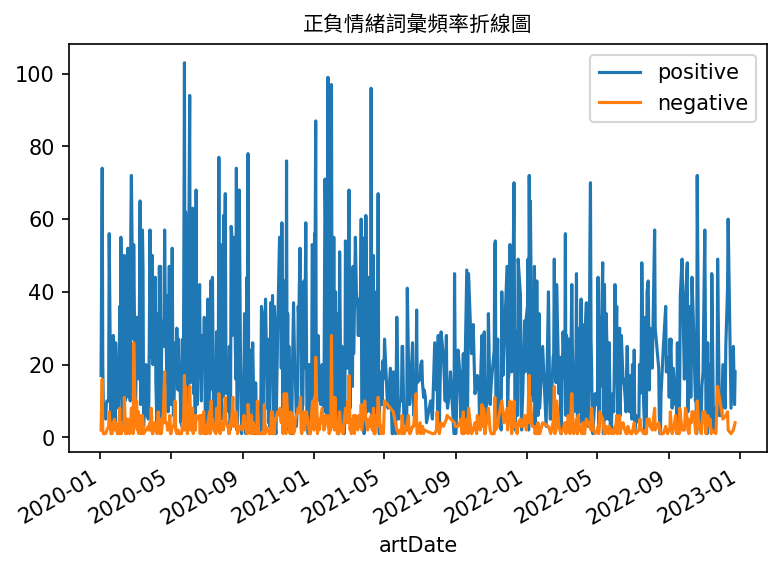

In [157]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

```Moving average```
- rolling average（滾動平均）是一種將時間序列數據平滑化的技術，有助於去除數據中的噪聲，使趨勢更加明顯，同時仍然保留一定的時間特徵。
- 在情緒分析中，特別是當你有一系列時間序列的情緒數據時，使用滾動平均有助於平滑數據，使情緒趨勢更加清晰。
    1. **去除瞬間噪聲**： 情緒數據可能受到瞬間事件或噪聲的影響，例如突發的大量評論或新聞。滾動平均有助於平滑這些突變，使你更容易觀察到整體趨勢。
    2. **強調長期趨勢**： 滾動平均有助於強調長期情緒趨勢，而不受短期波動的干擾。這對於觀察情緒的漸變和長期變化非常有用。


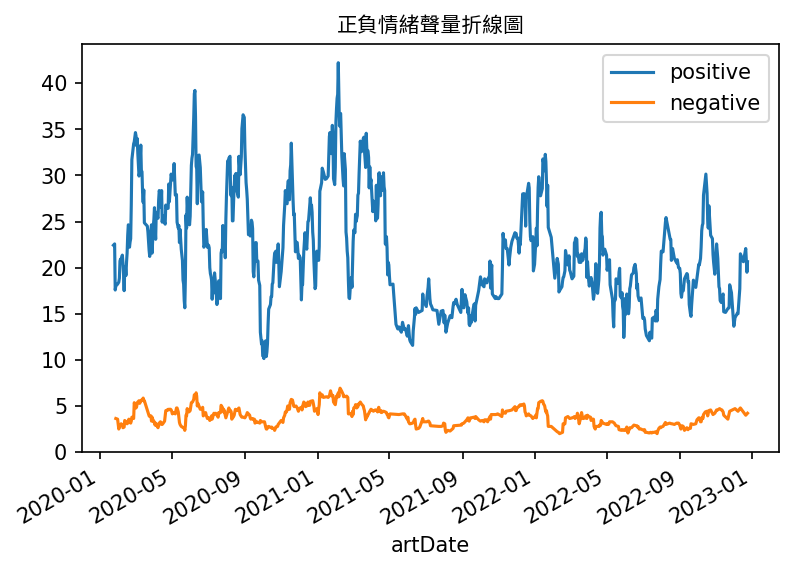

In [158]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

畫出每天的情緒總分數，可以看到正面的詞出現頻率幾乎每天都超過負面，是個氣氛和諧的討論版。

```詞頻缺點```

如果某一天有什麼事件發生而導致正負向詞頻數隨之飆高，在趨勢圖看來可能會認為該區間的正負向情緒較為顯著，但也有可能是因為總體情緒詞彙本來就比較多而導致的。

以比例的方式來看，我們可以觀察到某個情緒詞在總體情緒詞彙中所佔的比例，就算某一天文章數相較多，也不會影響到比例的呈現。

### 3.4 正負向情緒詞彙比例折線圖圖

```lambda```函式是一種匿名函式，包含以下幾點特性：

+ 不需要定義函式名稱
+ 只能有一行運算式
+ 執行完後會自動回傳結果，不需要return   

因此```lambda```適合在該函式只有單行運算式且不會被重複呼叫時使用

參考網址：   
[Python Lambda](https://www.w3schools.com/python/python_lambda.asp)   
[Lambda — Python 重要語法技巧](https://medium.com/johnliu-的軟體工程思維/lambda-python-重要語法技巧-27c467ddfa16)

In [159]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
1,2020-01-02,negative,2,0.105263
2,2020-01-02,positive,17,0.894737
6,2020-01-04,negative,16,0.177778
7,2020-01-04,positive,74,0.822222
10,2020-01-05,negative,2,0.090909
...,...,...,...,...
2756,2022-12-21,positive,25,0.925926
2755,2022-12-21,negative,2,0.074074
2759,2022-12-23,positive,9,1.000000
2761,2022-12-24,negative,4,0.181818


In [160]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

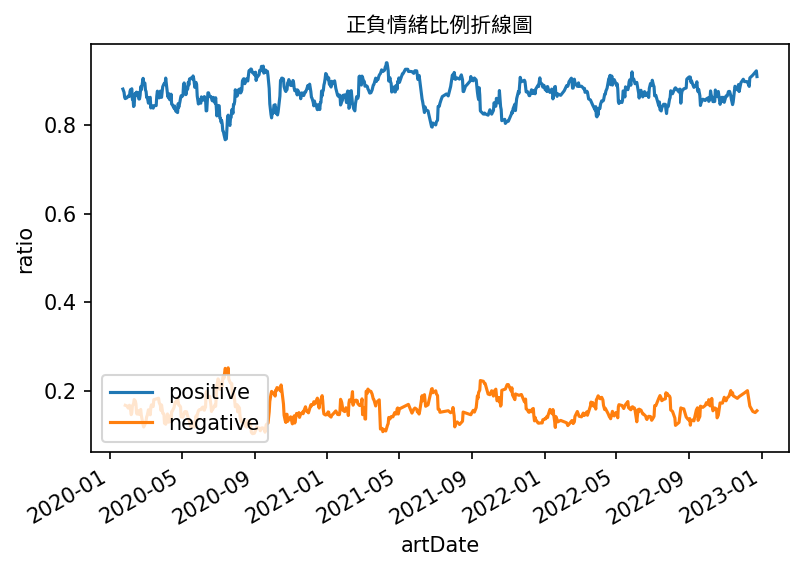

In [161]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

### 3.5 正負向情緒分數折線圖

In [162]:
sentiment_count

,artDate,sentiments,size,ratio
1,2020-01-02,negative,2,0.105263
2,2020-01-02,positive,17,0.894737
6,2020-01-04,negative,16,0.177778
7,2020-01-04,positive,74,0.822222
10,2020-01-05,negative,2,0.090909
...,...,...,...,...
2756,2022-12-21,positive,25,0.925926
2755,2022-12-21,negative,2,0.074074
2759,2022-12-23,positive,9,1.000000
2761,2022-12-24,negative,4,0.181818


In [163]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,negative,positive
0,2020-01-02,2.0,17.0
1,2020-01-04,16.0,74.0
2,2020-01-05,2.0,20.0
3,2020-01-06,1.0,8.0
4,2020-01-10,1.0,5.0


In [164]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2020-01-02,2.0,17.0,15.0
1,2020-01-04,16.0,74.0,58.0
2,2020-01-05,2.0,20.0,18.0
3,2020-01-06,1.0,8.0,7.0
4,2020-01-10,1.0,5.0,4.0


Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

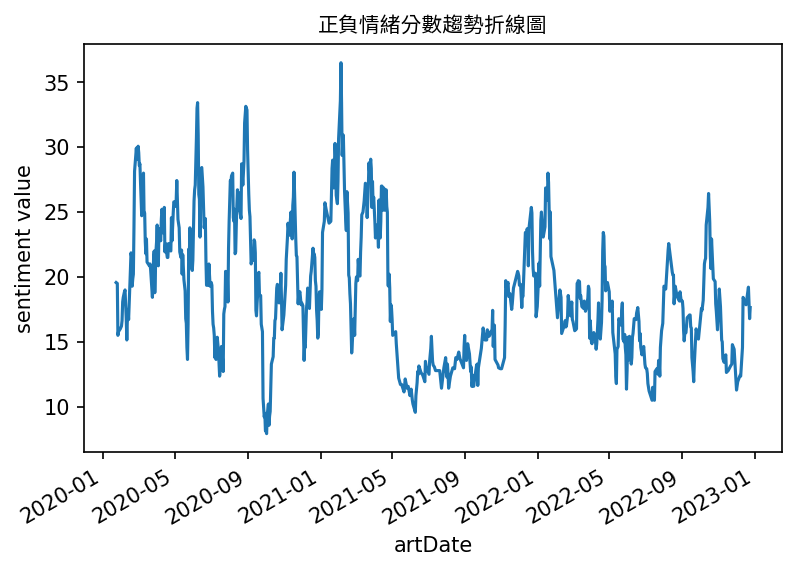

In [165]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 3.6 文章為單位的情緒分析

In [166]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

,artUrl,sentiments,size
0,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,affect,9
1,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,negative,2
2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,positive,6
3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,affect,11
4,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,positive,11
...,...,...,...
4114,https://www.ptt.cc/bbs/Food/M.1671727552.A.F4D...,positive,9
4115,https://www.ptt.cc/bbs/Food/M.1671812237.A.F57...,affect,23
4116,https://www.ptt.cc/bbs/Food/M.1671812237.A.F57...,negative,4
4117,https://www.ptt.cc/bbs/Food/M.1671812237.A.F57...,positive,18


In [167]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,9.0,0.0,0.0,2.0,6.0,0.0
1,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,11.0,0.0,0.0,0.0,11.0,0.0
2,https://www.ptt.cc/bbs/Food/M.1578120136.A.276...,12.0,1.0,1.0,2.0,10.0,0.0
3,https://www.ptt.cc/bbs/Food/M.1578125940.A.9AA...,26.0,0.0,1.0,4.0,19.0,0.0
4,https://www.ptt.cc/bbs/Food/M.1578132815.A.32F...,59.0,1.0,1.0,10.0,45.0,2.0


In [168]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,9.0,0.0,0.0,2.0,6.0,0.0,4.0
1,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,11.0,0.0,0.0,0.0,11.0,0.0,11.0
2,https://www.ptt.cc/bbs/Food/M.1578120136.A.276...,12.0,1.0,1.0,2.0,10.0,0.0,8.0
3,https://www.ptt.cc/bbs/Food/M.1578125940.A.9AA...,26.0,0.0,1.0,4.0,19.0,0.0,15.0
4,https://www.ptt.cc/bbs/Food/M.1578132815.A.32F...,59.0,1.0,1.0,10.0,45.0,2.0,35.0


In [169]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,9.0,0.0,0.0,2.0,6.0,0.0,4.0,正向
1,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,11.0,0.0,0.0,0.0,11.0,0.0,11.0,正向
2,https://www.ptt.cc/bbs/Food/M.1578120136.A.276...,12.0,1.0,1.0,2.0,10.0,0.0,8.0,正向
3,https://www.ptt.cc/bbs/Food/M.1578125940.A.9AA...,26.0,0.0,1.0,4.0,19.0,0.0,15.0,正向
4,https://www.ptt.cc/bbs/Food/M.1578132815.A.32F...,59.0,1.0,1.0,10.0,45.0,2.0,35.0,正向
...,...,...,...,...,...,...,...,...,...
1259,https://www.ptt.cc/bbs/Food/M.1671624944.A.9BC...,17.0,1.0,0.0,1.0,15.0,0.0,14.0,正向
1260,https://www.ptt.cc/bbs/Food/M.1671632077.A.A02...,14.0,0.0,0.0,1.0,10.0,1.0,9.0,正向
1261,https://www.ptt.cc/bbs/Food/M.1671727552.A.F4D...,10.0,0.0,0.0,0.0,9.0,0.0,9.0,正向
1262,https://www.ptt.cc/bbs/Food/M.1671812237.A.F57...,23.0,0.0,0.0,4.0,18.0,0.0,14.0,正向


In [170]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentiment_class
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,ideos,Food,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,[],111.250.1.231,2020-01-02 00:21:09,ptt,NaN
1,2,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02,justin81828,Food,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KKyosuke"", ""...",118.169.82.96,2020-01-03 00:22:27,ptt,正向
2,3,https://www.ptt.cc/bbs/Food/M.1577985452.A.477...,[食記]台北大安區六張犁站捷運小慧涼麵,2020-01-02,v84454058,Food,餐廳名稱：小慧涼麵\n 消費時間：2018年/11月起多訪\n 地址：台北市大安區臥...,[],123.194.196.149,2020-01-03 00:22:34,ptt,正向
3,4,https://www.ptt.cc/bbs/Food/M.1578120136.A.276...,[食記]福岡-運河城旁國產牛燒肉-WEST,2020-01-04,Guyinkt,Food,消費時間：2019年/08月\n\n在運河城逛累了當然要吃東西補充體力了喔!\n\nWEST...,[],220.134.201.135,2020-01-05 00:21:43,ptt,正向
4,5,https://www.ptt.cc/bbs/Food/M.1578125940.A.9AA...,[食記]長榮皇璽桂冠艙飛機餐SEA-TPE聖誕好運,2020-01-04,Sherlock56,Food,店名：長榮皇璽桂冠艙飛機餐\n 地址：無\n 電話：無\n 營業時間：依機艙供餐...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""swatseal"", ""...",121.109.166.209,2020-01-05 00:21:43,ptt,正向
...,...,...,...,...,...,...,...,...,...,...,...,...
1625,1626,https://www.ptt.cc/bbs/Food/M.1671727552.A.F4D...,[請益]代烤的套餐式燒肉店,2022-12-23,eva577663,Food,請填寫發問範本並保留項目名稱：\n【選填項目】可參酌需求自行決定是否填寫\n【必填項目】未填...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""cpcsteven"", ...",119.14.204.151,2022-12-23 01:11:28,ptt,正向
1626,1627,https://www.ptt.cc/bbs/Food/M.1671812237.A.F57...,[食記]謝阿姨美食坊450元吃無菜單跟芋頭粥到飽,2022-12-24,ruth0204,Food,餐廳名稱：謝阿姨美食坊\n 消費時間：2022年/11月\n 地址： 100台北市中...,[],111.241.212.127,2022-12-24 01:11:17,ptt,正向
1627,1628,https://www.ptt.cc/bbs/Food/M.1672065694.A.96C...,[食記]台北聚北海道鍋物台北衡陽店,2022-12-26,nikcoke,Food,鍋物最前線--聚北海道鍋物台北衡陽店\n\n消費日期：2022 年 9 月\n\n有圖有真相...,[],210.64.197.193,2022-12-27 01:11:02,ptt,負向
1628,1629,https://www.ptt.cc/bbs/Food/M.1672150855.A.A0B...,[食記]台南把把串麻辣鍋10元串串458吃到飽,2022-12-27,lumike0602,Food,餐廳名稱：把把串麻辣鍋\n\n消費時間：2022年/12月\n\n地址：台南市永康區中華路5...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""eo8h1"", ""cmt...",39.14.35.13,2022-12-28 01:11:12,ptt,NaN


In [171]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2020-01-02,正向,2
1,2020-01-04,正向,3
2,2020-01-05,正向,2
3,2020-01-06,正向,2
4,2020-01-10,正向,1
...,...,...,...
795,2022-12-17,正向,2
796,2022-12-21,正向,2
797,2022-12-23,正向,1
798,2022-12-24,正向,1


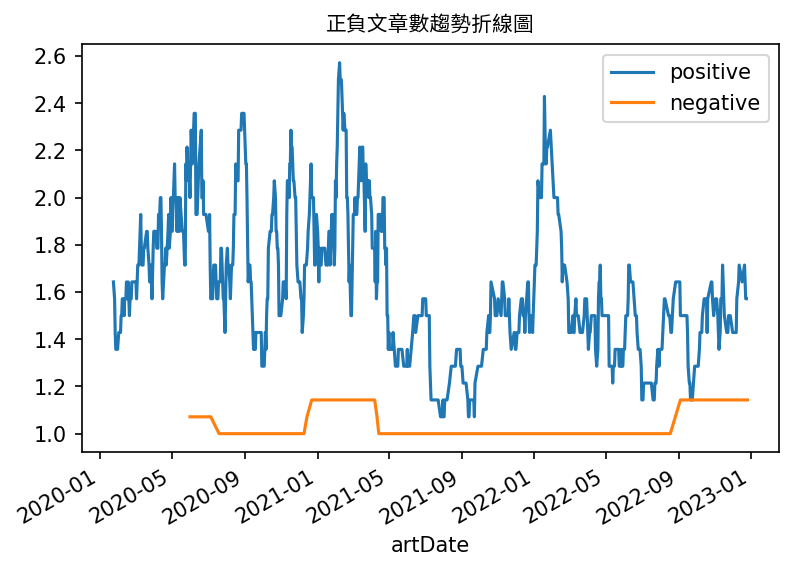

In [172]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

大部分文章都被歸類在正向文章，美食版討論內容大多偏正面

### 3.7 情緒代表字

In [173]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
52,不錯,affect,2144
53,不錯,positive,2144
316,喜歡,positive,1718
315,喜歡,affect,1718
401,好吃,affect,1702
...,...,...,...
124,傻瓜,anger,1
1056,白癡,affect,1
1057,白癡,anger,1
1058,白癡,negative,1


In [174]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
53,不錯,positive,2144
316,喜歡,positive,1718
402,好吃,positive,1702
799,朋友,positive,708
1364,適合,positive,693
1318,豐富,positive,415
1177,美味,positive,392
133,優惠,positive,294
155,免費,positive,291
1114,簡單,positive,290


In [175]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
302,問題,negative,201
726,擔心,negative,112
1393,錯過,negative,104
1423,隨便,negative,79
390,失望,negative,78
1163,缺點,negative,77
1501,麻煩,negative,59
514,強烈,negative,52
707,控制,negative,50
47,不足,negative,47


/var/folders/6t/4zddl4td2y17gcdkvdjnwk4m0000gn/T/ipykernel_7241/391454114.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
/var/folders/6t/4zddl4td2y17gcdkvdjnwk4m0000gn/T/ipykernel_7241/391454114.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

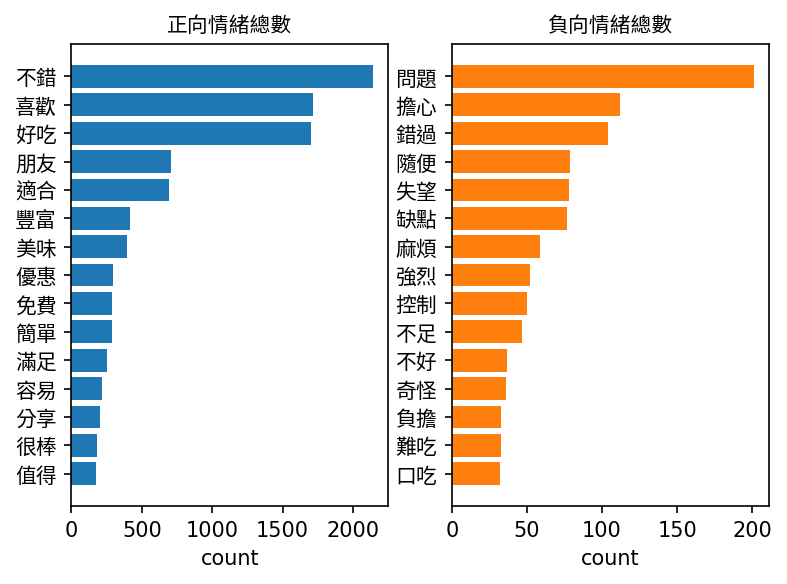

In [176]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

#### 檢查情緒詞是否符合本文本

In [177]:
filtered_df = sent_df[sent_df['sentence'].str.contains('控制', na=False)]
filtered_df.head()

,artUrl,artTitle,artDate,artContent,sentence
750,https://www.ptt.cc/bbs/Food/M.1578797582.A.B58...,[食記]高雄好好吃肉韓式烤肉吃到飽食肉怪必吃,2020-01-12,店名：好好吃肉 韓式烤肉吃到飽\n\n地址：高雄市左營區博愛二路160號 （捷運凹子底站三號...,原味鮮豬倒是不錯 不過火侯要控制得當 才能煎出金黃色的感覺
5429,https://www.ptt.cc/bbs/Food/M.1582815686.A.286...,[食記]高雄義大牛角單點品質尚可牛五花偏油,2020-02-27,餐廳名稱：牛角日式燒肉 高雄義大店\n 消費時間：2019年11月\n 店家地址：高...,不過火力上會比較好控制
6289,https://www.ptt.cc/bbs/Food/M.1583507394.A.A93...,[食記]高雄舞古賀鍋物還不錯吃的中價位火鍋,2020-03-06,餐廳名稱：舞古賀鍋物專門店 頂級肉品平價專賣\n 消費時間：2019年10月\n 店...,但是品款控制的不錯
6535,https://www.ptt.cc/bbs/Food/M.1583754204.A.CBA...,[食記]新竹火山岩燒肉印地安主題無煙燒烤,2020-03-09,★火山岩燒肉竹北旗艦店★\n地址：302新竹縣竹北市自強北路230號\n電話：03 668 ...,火山岩燒肉的烤爐非炭火烤爐是瓦斯爐的方式自由控制火力大小烤的過程不會一直被煙燻 吃完身上也不...
9632,https://www.ptt.cc/bbs/Food/M.1586331347.A.066...,[食記]新北永和51bbq韓式小菜無限供應,2020-04-08,餐廳名稱： 51bbq 韓國烤肉\n\n 消費時間：2020年/3月\n\n 地址...,當然可能是要控制成本


In [178]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

原味鮮豬倒是不錯 不過火侯要控制得當 才能煎出金黃色的感覺
不過火力上會比較好控制
但是品款控制的不錯
火山岩燒肉的烤爐非炭火烤爐是瓦斯爐的方式自由控制火力大小烤的過程不會一直被煙燻 吃完身上也不會有烤肉的油煙味
當然可能是要控制成本
可以考慮烤蝦我覺得有居酒屋烤物水準恰到剛好的魚下巴蔬菜天婦羅油溫控制不錯不會很油膩
好處是幾乎不太需要排隊就可以挖到  溫度也控制得很好不會過硬
因為必須精準地控制火侯
麵條軟硬控制得恰到好處 
但上菜時會盡可能單輪一次上完建議可以在每次菜單交遞返回立即畫下一輪再交出數量上要控制別太多避免吃不完
可能還需要有點調整的空間烤肉部份有提供烤紙也不限定只能換幾張比較不會有壓力XD加上烤紙其實真的蠻好烤火力控制上面也簡單建議一開始先烤沒有醃過的肉後面再把有醃過的肉一起烤否則烤紙報銷率真的是會很高XD原味五花豬附上的剪刀也很好剪
可以搭配免費的白飯火侯控制不錯牛肉片也很嫩
每個座位前方都有一個透過開關控制的窗口
不管是壽喜燒或者是火鍋肉一片一片的涮才容易控制熟度牛肉大概7到8秒最剛好肉算蠻薄的很好燙
只是要控制好時間
也可以直接搭配天婦羅炸直接吃也是不錯不過可能會覺得有點鹹明太子是可以無限續加的不過也是建議酌量享用不要樂極生悲哈哈半熟蛋炸的真的很不錯控制很剛好
其實很多炸豬排專賣都已經三字頭起跳這邊290套餐就已經算滿豐富炸物控制都還不錯飯可能有點偏硬
牛肉切開後呈現淡粉完全就是高價牛排館水準我們點五分熟控制的非常好通常這種傳統牛排
燒烤爐是使用瓦斯控制並非炭火
跳上一階的牛排可以選菲力牛排低油脂軟嫩部位是很多台灣人喜好的選擇採用厚切熟度控制得宜這邊的價位除了爐烤外
但是在火候控制上比較簡單
也請控制好毛小孩別讓他們亂叫喔
 如果非全熟也比較好控制
但上桌時熟度有些沒控制好
火力也很好控制
   因為那陣子他有在控制體重
我倒是覺得甜度都有控制住
烤的時間控制的很剛好 炸蝦處理外酥內嫩
畢竟不能控制炭火的大小烤蚵仔需要時間
自己烤就可以自己控制牛肉熟度
燒肉要快就是同樣厚度肉要一起來一開始較猛烈的炭火比較容易控制這種有厚度肉品熟度大家可以參考看看
接著烤肉部分這邊使用瓦斯爐三段火力穩定爐子面積也還蠻大的速度快因為都是有厚度的肉片為主所以用瓦斯的確比較容易控制想要5分還是7分熟像是澳洲和牛我自己是希望可以5分大概30秒多就可以
而且也不能控制火侯

#### 重新計算情緒

控制、問題、擔心、錯過、隨便、強烈、負擔、口吃、挑剔、壓力、邪惡、禁止

In [179]:
# 設定要移除的字詞列表
words_to_remove = ['問題','控制','擔心','錯過','隨便','強烈','負擔','口吃','挑剔','壓力','邪惡','禁止']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,咖哩,NaN
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,2019,NaN
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,112,NaN
3,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,2010,NaN
4,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,提供,NaN


/var/folders/6t/4zddl4td2y17gcdkvdjnwk4m0000gn/T/ipykernel_7241/1465679712.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
/var/folders/6t/4zddl4td2y17gcdkvdjnwk4m0000gn/T/ipykernel_7241/1465679712.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

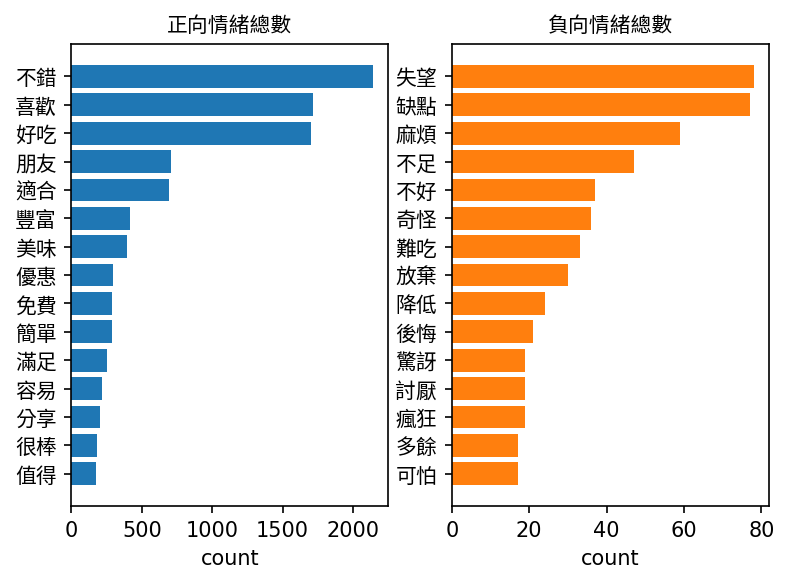

In [180]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

重新繪製情緒分數趨勢圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

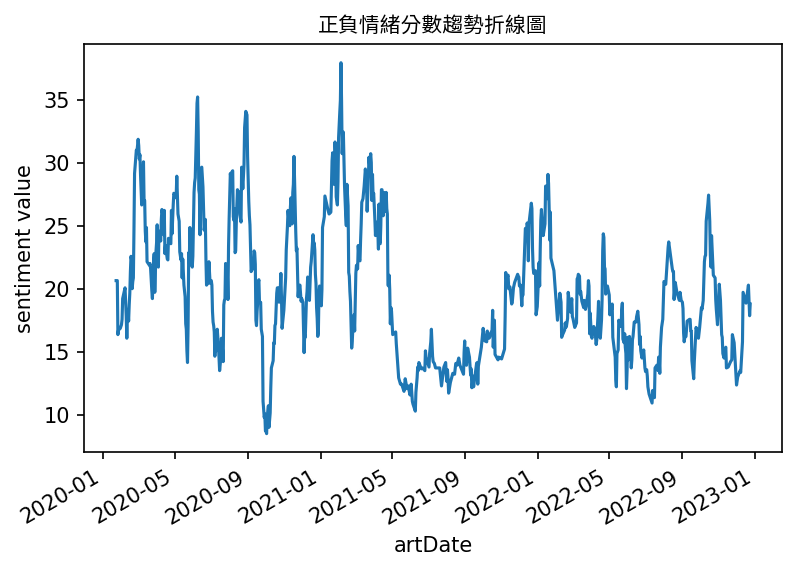

In [181]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 3.8 文字雲
如果文字雲中的字詞大小越大，代表出現頻率越高

#### 2021-05-15 ~2021-09-15 文字雲
2021-05-15 ~2021-09-15 在情緒分數趨勢圖上顯示比較低的分數，我們用文字雲來看一下這段時間出現了什麼關鍵字

將前面計算出的文章情緒類別合併，以利我們過濾出負面文章資料

In [182]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,咖哩,NaN,NaN
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,2019,NaN,NaN
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,112,NaN,NaN
3,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,2010,NaN,NaN
4,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,2020-01-02,[食記]台北中正濃咖哩平價美味份量大,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,提供,NaN,NaN


In [183]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
0,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩 消費時間2019年112月 例2010年7月,NaN
1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,未提供則文章不予保留,NaN
2,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,多訪綜合心得也請標上起迄時間 地址台北市開封街1段78巷2號 電話0906 492 ...,NaN
3,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,餐廳名稱乾杯,正向
4,https://www.ptt.cc/bbs/Food/M.1577983692.A.794...,[抱怨]ATT4FUN乾杯點沙朗多注意,2020-01-02,餐廳名稱：乾杯\n\n 地址：ATT4FUN 乾杯\n 電話：02-87860808\n...,地址ATT4FUN 乾杯 電話0287860808 消費時間2020年1月1號 事...,正向


In [184]:
date = "2021-05-15"
end_date = "2021-09-15"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
244845,https://www.ptt.cc/bbs/Food/M.1622033564.A.644...,2021-05-26,[食記]台北徹思叔叔的咖啡廳蛋糕吃到飽,冰品甜點吃到飽系列之--徹思叔叔的咖啡廳\n\n消費日期：2021 年 1 月\n\n有圖有...,冰品,NaN,負向
244846,https://www.ptt.cc/bbs/Food/M.1622033564.A.644...,2021-05-26,[食記]台北徹思叔叔的咖啡廳蛋糕吃到飽,冰品甜點吃到飽系列之--徹思叔叔的咖啡廳\n\n消費日期：2021 年 1 月\n\n有圖有...,甜點,NaN,負向
244847,https://www.ptt.cc/bbs/Food/M.1622033564.A.644...,2021-05-26,[食記]台北徹思叔叔的咖啡廳蛋糕吃到飽,冰品甜點吃到飽系列之--徹思叔叔的咖啡廳\n\n消費日期：2021 年 1 月\n\n有圖有...,系列,NaN,負向
244848,https://www.ptt.cc/bbs/Food/M.1622033564.A.644...,2021-05-26,[食記]台北徹思叔叔的咖啡廳蛋糕吃到飽,冰品甜點吃到飽系列之--徹思叔叔的咖啡廳\n\n消費日期：2021 年 1 月\n\n有圖有...,之徹思,NaN,負向
244849,https://www.ptt.cc/bbs/Food/M.1622033564.A.644...,2021-05-26,[食記]台北徹思叔叔的咖啡廳蛋糕吃到飽,冰品甜點吃到飽系列之--徹思叔叔的咖啡廳\n\n消費日期：2021 年 1 月\n\n有圖有...,叔叔,NaN,負向
...,...,...,...,...,...,...,...
266033,https://www.ptt.cc/bbs/Food/M.1631713884.A.384...,2021-09-15,[食記][中西]新馬辣經典麻辣鍋｜Plus+台南西門,作者: reesion (阿湯哥) 看板: Tainan\n標題: [食記][中西] 新馬辣...,尺寸,NaN,負向
266034,https://www.ptt.cc/bbs/Food/M.1631713884.A.384...,2021-09-15,[食記][中西]新馬辣經典麻辣鍋｜Plus+台南西門,作者: reesion (阿湯哥) 看板: Tainan\n標題: [食記][中西] 新馬辣...,美國,NaN,負向
266035,https://www.ptt.cc/bbs/Food/M.1631713884.A.384...,2021-09-15,[食記][中西]新馬辣經典麻辣鍋｜Plus+台南西門,作者: reesion (阿湯哥) 看板: Tainan\n標題: [食記][中西] 新馬辣...,火雞,NaN,負向
266036,https://www.ptt.cc/bbs/Food/M.1631713884.A.384...,2021-09-15,[食記][中西]新馬辣經典麻辣鍋｜Plus+台南西門,作者: reesion (阿湯哥) 看板: Tainan\n標題: [食記][中西] 新馬辣...,念佛,NaN,負向


In [185]:
date = "2021-05-15"
end_date = "2021-09-15"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
560,牛排,22
534,火鍋,13
40,2021,11
438,新馬辣,10
692,蔬菜,10
...,...,...
345,家裡,1
346,對切,1
347,對半,1
348,小朋友,1


(-0.5, 399.5, 199.5, -0.5)

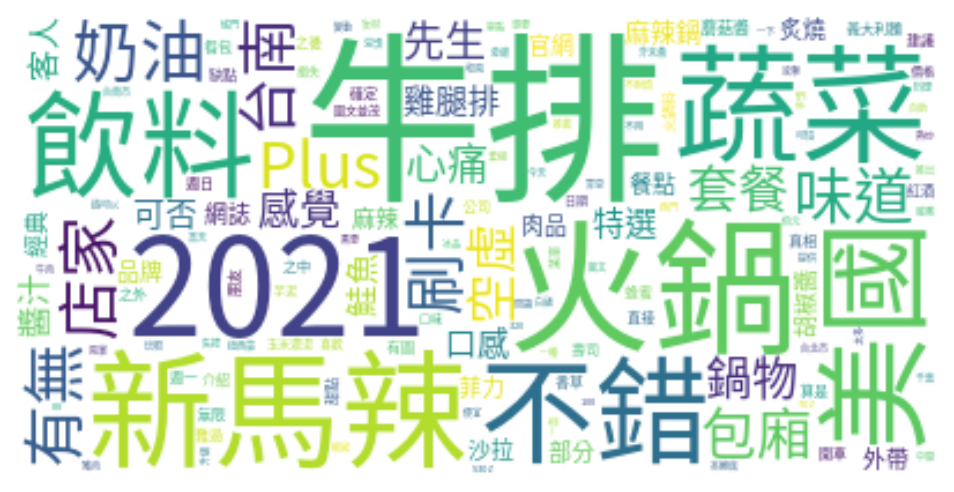

In [186]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

關鍵字出現了「牛排」、「雞腿排」的關鍵字，可能是在說明某間排餐的文章

(-0.5, 399.5, 199.5, -0.5)

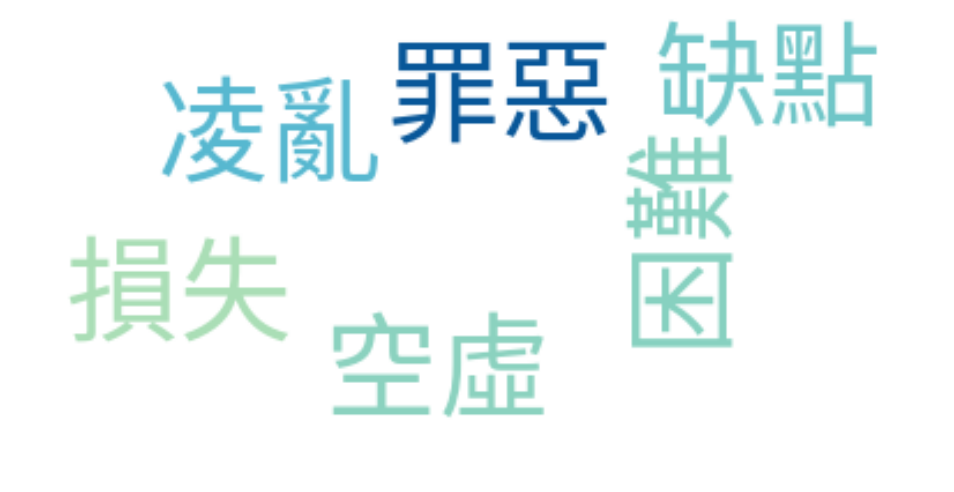

In [187]:
date = "2021-05-15"
end_date = "2021-09-15"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('雞腿排')) & ( # 內文包含雞腿排
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

利用「缺點」去查看原文內容

In [188]:
date = "2021-05-15"
end_date = "2021-09-15"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('雞腿排')) & (
    sent_df['sentence'].str.contains('缺點')) # 包含「缺點」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
57723,https://www.ptt.cc/bbs/Food/M.1624553845.A.EEF...,[廣宣]高雄牛排先生炙燒炭烤牛排防疫特別套餐,2021-06-25,餐廳名稱：牛排先生 炙燒炭烤牛排\n 消費時間：2021年06月\n 店家地址：高雄...,而且味道上也處理的很棒,負向
57724,https://www.ptt.cc/bbs/Food/M.1624553845.A.EEF...,[廣宣]高雄牛排先生炙燒炭烤牛排防疫特別套餐,2021-06-25,餐廳名稱：牛排先生 炙燒炭烤牛排\n 消費時間：2021年06月\n 店家地址：高雄...,可以得到微鹹不過度的雞腿肉,負向
57725,https://www.ptt.cc/bbs/Food/M.1624553845.A.EEF...,[廣宣]高雄牛排先生炙燒炭烤牛排防疫特別套餐,2021-06-25,餐廳名稱：牛排先生 炙燒炭烤牛排\n 消費時間：2021年06月\n 店家地址：高雄...,如果有白飯搭配起來應該會很合適,負向
57726,https://www.ptt.cc/bbs/Food/M.1624553845.A.EEF...,[廣宣]高雄牛排先生炙燒炭烤牛排防疫特別套餐,2021-06-25,餐廳名稱：牛排先生 炙燒炭烤牛排\n 消費時間：2021年06月\n 店家地址：高雄...,不過在這個餐盒之中,負向
57727,https://www.ptt.cc/bbs/Food/M.1624553845.A.EEF...,[廣宣]高雄牛排先生炙燒炭烤牛排防疫特別套餐,2021-06-25,餐廳名稱：牛排先生 炙燒炭烤牛排\n 消費時間：2021年06月\n 店家地址：高雄...,就配點馬鈴薯泥吧,負向
57728,https://www.ptt.cc/bbs/Food/M.1624553845.A.EEF...,[廣宣]高雄牛排先生炙燒炭烤牛排防疫特別套餐,2021-06-25,餐廳名稱：牛排先生 炙燒炭烤牛排\n 消費時間：2021年06月\n 店家地址：高雄...,如果要說缺點,負向
57729,https://www.ptt.cc/bbs/Food/M.1624553845.A.EEF...,[廣宣]高雄牛排先生炙燒炭烤牛排防疫特別套餐,2021-06-25,餐廳名稱：牛排先生 炙燒炭烤牛排\n 消費時間：2021年06月\n 店家地址：高雄...,那大概就是皮不是那種脆脆的口感,負向
57730,https://www.ptt.cc/bbs/Food/M.1624553845.A.EEF...,[廣宣]高雄牛排先生炙燒炭烤牛排防疫特別套餐,2021-06-25,餐廳名稱：牛排先生 炙燒炭烤牛排\n 消費時間：2021年06月\n 店家地址：高雄...,如果可以做到肉Q而皮脆,負向
57731,https://www.ptt.cc/bbs/Food/M.1624553845.A.EEF...,[廣宣]高雄牛排先生炙燒炭烤牛排防疫特別套餐,2021-06-25,餐廳名稱：牛排先生 炙燒炭烤牛排\n 消費時間：2021年06月\n 店家地址：高雄...,那就真的很厲害,負向
57732,https://www.ptt.cc/bbs/Food/M.1624553845.A.EEF...,[廣宣]高雄牛排先生炙燒炭烤牛排防疫特別套餐,2021-06-25,餐廳名稱：牛排先生 炙燒炭烤牛排\n 消費時間：2021年06月\n 店家地址：高雄...,不過也應該不會賣這個價格了XDDDD,負向


文章中提到了這間排餐的雞腿排的皮處理得不夠酥脆